### 1_axle_tree_exercise

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools
import json
import os

In [2]:
def open_json_from_file(json_path):
    """
    Loads a json from a file path.

    :param json_path: path to the json file
    :return: the loaded json
    """
    try:
        with open(json_path) as json_file:
            json_data = json.load(json_file)
    except:
        print("Could not open file %s in json format." %json_path)
        raise

    return json_data

def save_json_to_file(json_data, json_path):
    """
    Saves a json to a file.

    :param json_data: the actual json
    :param json_path: path to the json file
    :return:
    """
    try:
        with open(json_path, 'w') as json_file:
            json.dump(json_data, json_file, indent=2)
    except:
        print("Could not save file %s in json format." %json_path)
        raise

    return

def pretty_print(inline_json):
    """
    Prints a json in the command interface in easily-readable format.

    :param inline_json:
    :return:
    """
    pretty_json = json.dumps(inline_json, indent=4, sort_keys=True)
    print(pretty_json)
    
    return

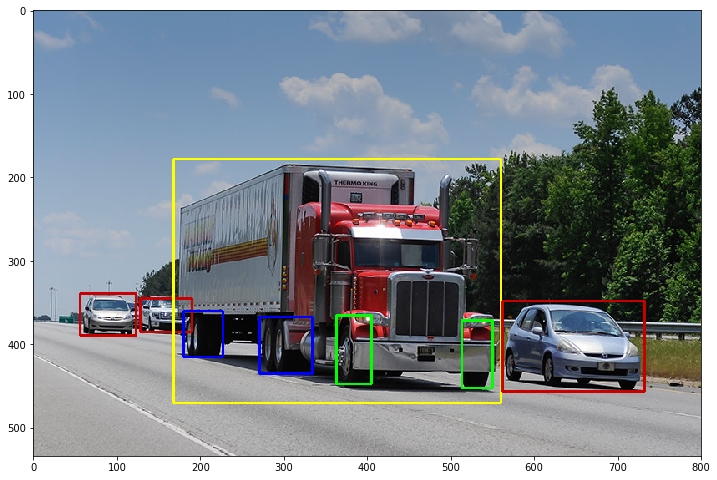

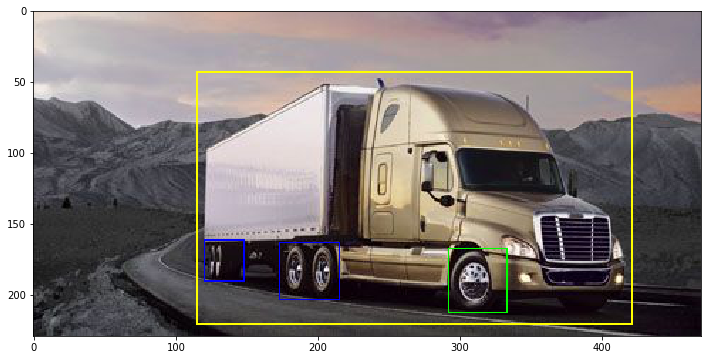

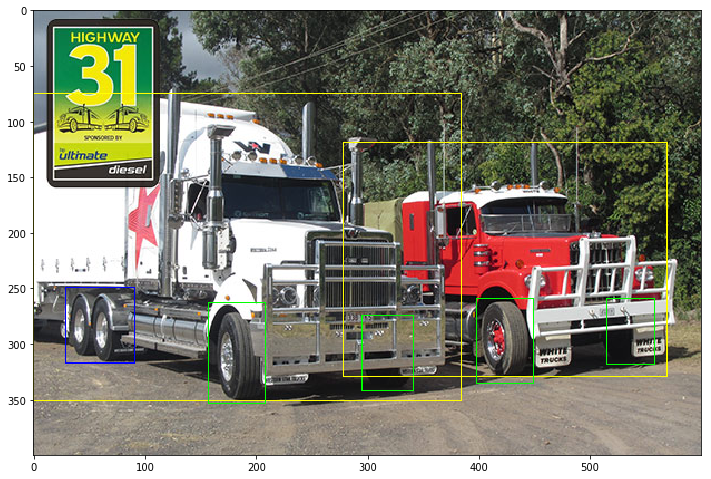

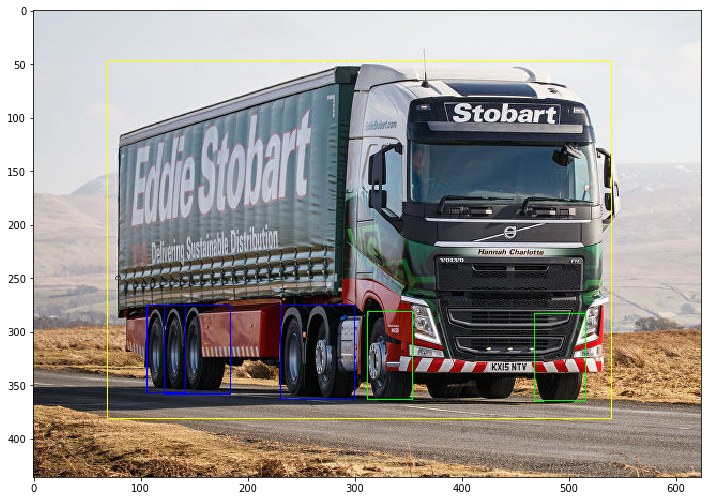

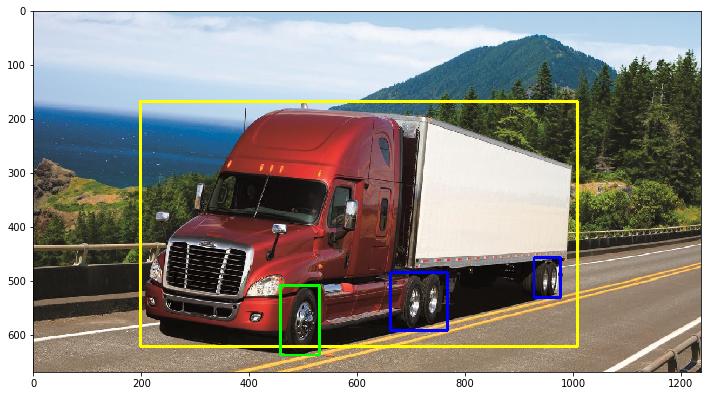

In [47]:
# implemented functions
"""
There faster libraries to compute the polygon intersection such us shapely, geopandas, etc.
I opted for implementing them this time.
"""

def get_t_area(boxA, boxB):

    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return boxA_area + boxB_area

def get_i_area(boxA, boxB, margin=0):
    # coordinates of the intersection polygon
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # area
    i_area = max(0, xB - xA + margin) * max(0, yB - yA + margin)
    return i_area

def get_u_area(boxA, boxB, retur=True):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = min(boxA[0], boxB[0])
    yA = min(boxA[1], boxB[1])
    xB = max(boxA[2], boxB[2])
    yB = max(boxA[3], boxB[3])
    
    i_area = get_i_area(boxA, boxB)
    t_area = get_t_area(boxA, boxB)
    u_area = t_area - i_area
    
    u_bb = [xA, yA, xB, yB]
    
    return u_area, u_bb

def plot_im(im, title=None):
    nrows, ncols = 1, 1
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(10, 10)
    fig.tight_layout()
    if title is not None: plt.title(title)
    ax.imshow(im) 
    
def get_bb_list(im, bb_data):
    
    coor = bb_data['region']
    # bottom left corner (lower corner)
    lc = (int(coor['xmin']*im.shape[1]), int(coor['ymin']*im.shape[0]))
    # upper right corner (higer corner)
    hc = (int(coor['xmax']*im.shape[1]), int(coor['ymax']*im.shape[0]))
    bbox = [lc[0], lc[1], hc[0], hc[1]]
    
    return bbox

def get_intersected_bb_pairs(pairs, i_thres=.0):
    i_pairs = []
    for i, j in pairs:
        i_area = get_i_area(i, j, margin=3)
        if i_area  >  i_thres:
            i_pairs.append((i, j))
    
    return i_pairs

def merge_intersected_bb_pairs(pairs):
    m_pairs = []
    for i, j in pairs:
        u_area, u_bb = get_u_area(i, j)
        m_pairs.append(u_bb)
    return m_pairs

def fill_bbox_template(bb_type, bbox):
    bb_template = {
        "tags": [bb_type],
        "region_type": "Box",
        "region": {
            "xmin": bbox[0]/im.shape[1],
            "ymin": bbox[1]/im.shape[0],
            "xmax": bbox[2]/im.shape[1],
            "ymax": bbox[3]/im.shape[0],
        }
}
    return bb_template

if __name__ == '__main__':
    
    # Load annotations from json file
    json_data = open_json_from_file('annotations.json')

    """--------------"""
    data = pd.io.json.json_normalize(json_data['images'])

    col_dic = {'single_axle': (0, 255, 0), 'car': (200, 0, 0), 'other': (255, 255, 0), 'grouped_axles': (0, 0, 255)}
    new_json_data = {
        "tags": ["single_axle", "grouped_axles", "car", "other"],
        "images": []
    }
    
    out_p = 'output/' # output path
    if not os.path.exists(out_p): os.makedirs(out_p)
    
    bb_data = {}
    new_bb_data = {}
    for _, (im_p, bboxs) in enumerate(zip(data['location'], data['annotated_regions'])): 
        
        try: 
            im = cv2.imread(im_p, cv2.IMREAD_UNCHANGED)
            im = im[:,:,[2,1,0]].copy()
        except: 
            print('No image found for file name %s in %s' %(im_p, im_p))
            continue
                
        bb_data[im_p] = [{i['tags'][0]: get_bb_list(im, i)} for i in bboxs]            
                
        s_axle, g_axle, t_axel = [], [], []
        
        for bb in bb_data[im_p]:
            for bb_type, bbox in bb.items(): 
                if bb_type == 'single_axle': s_axle.append(bbox)
            
        pairs = itertools.combinations(s_axle, 2)
        i_pairs = get_intersected_bb_pairs(pairs)
        m_pairs = merge_intersected_bb_pairs(i_pairs)
        g_pairs = [j for pair in i_pairs for j in pair]
       
        [bb_data[im_p].append({'grouped_axles': i}) for i in m_pairs]
    
        for bb in bb_data[im_p]:
            for bb_type, bbox in bb.items(): 
                if bb_type == 'single_axle' and bbox in g_pairs: continue
                # new_bb_data[im_p] = {bb_type: bbox}
                cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[2], bbox[3]), col_dic[bb_type], int(3e-3*im.shape[1]))
            
        cv2.imwrite(out_p +  im_p.split('/')[1].split('.')[0] + '.png', im[:,:,[2,1,0]])
        
        plot_im(im)
        
        new_im_data = {im_p: [{bb_type: bbox} 
                              for bb in bb_data[im_p] 
                              for bb_type, bbox in bb.items() 
                              if not (bb_type == 'single_axle' and bbox in g_pairs)]}
                              # for im_p in bb_data.keys()}
        
        for im_p, bboxs in new_im_data.items():
            
            new_json_data["images"].append({
                "annotated_regions": [fill_bbox_template(bb_type, bbox) 
                                      for i in bboxs 
                                      for bb_type, bbox in i.items()],
                "location": im_p}) 
       
    """ -------------"""
    
    # pretty_print(new_json_data)
    # Saves new annotations to json file
    save_json_to_file(new_json_data, 'new_annotations.json')